In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import pylab as plt
%matplotlib inline

import seaborn as sns

In [3]:
target = 'case'

csv_fname = f'results_forecast/forecast_US_tweak_00.csv'
idx = csv_fname.split('/')[-1][:-4].split('_')[-1]

df_ours = pd.read_csv(csv_fname, index_col=0)
dates = pd.date_range(start='2020-04-11', freq='7D', periods=len(df_ours))

In [4]:
df_otherTeams_1 = pd.read_csv(f'../CovidTeam_results/forecast_otherTeam_1-wk-ahead-inc-{target}.csv', index_col=0, parse_dates=True)
dates_1 = dates + timedelta(days=7)

# df_otherTeams_2 = pd.read_csv('../CovidTeam_results/forecast_otherTeam_2-wk.csv', index_col=0, parse_dates=True)
# dates_2 = dates + timedelta(days=14)

In [5]:
cols = [x for x in df_ours.columns if x.endswith('1')]
df_ours_1 = df_ours[cols]
df_ours_1.index = dates_1
df_combined_1 = df_otherTeams_1.join(df_ours_1, how='outer')

# cols = [x for x in df_ours.columns if x.endswith('2')]
# df_ours_2 = df_ours[cols]
# df_ours_2.index = dates_2
# df_combined_2 = df_otherTeams_2.join(df_ours_2.loc['2020-07-11':, :]).drop('JHU-CSSE-DECOM', axis=1).dropna()

In [414]:
# def func(x, threshold=50):
#     a = (x['ET1'] - x['RF1']).abs().values
#     b = (x['ET1'] - x['RF1']).values
#     sign = np.array([a > threshold], int)[0]
#     result = sign * (x['avg1'] - x['TF1']) + x['avg1']
#     return result

# def func(x, c=.35):
#     return (x['ET1'] + x['RF1'] + c * x['TF1']) / (2 + c) 
    
# df_combined_1['avg1_modified'] = func(df_combined_1, 100)
# df_combined_1['avg1_modified'] = func(df_combined_1, .35)

# # df_combined_1[['Columbia-UNC-SurvCon', 'QJHong-Encounter', 'ET1', 'RF1', 'TF1', 'grd1',
# #        'avg1']].to_csv('combined.csv', float_format='%.0f')
# df_combined_1

In [415]:
# df_ours_1.join(df_otherTeams_1, how='outer')\
#     .to_csv(f'../../COVID_risk/Figures/data/forecast_compare_{target}_full_{idx}.csv', float_format='%.0f')

In [6]:
def func(x, c=.5):
    return (x['ET1'] + x['RF1'] + c * x['TF1']) / (2 + c) 


def panel_func(arr, gamma=0.0001):
    panel = [1.]
    for a in arr:
        if a < 0:
            panel.append(1)
        else:
            p = np.exp(-gamma * a)
            panel.append(p)
    return np.array(panel)


def panel_func(arr, gamma=0.0001):
    panel = []
    for a in arr:
        p = np.exp(-gamma * a)
        panel.append(p)        
    return np.array(panel)


# df_combined_1 = pd.read_csv('/home/yihuang/Downloads/combined.csv', index_col=0)
# d = 2.6
df_combined_1['zed'] = func(df_combined_1, 0.5)
# A = df_combined_1.zed.ewm(alpha=.6).mean()
# B = df_combined_1.grd1.values
# B = np.append(B[0], B[:-1])
# A = d * A + (1 - d) * B
# df_combined_1['zed'] = A

# z = df_combined_1['zed'].reset_index(drop=True).values
# g = df_combined_1['grd1'].reset_index(drop=True).values
# panel = z[1:] - g[:-1]

panel = panel_func(df_combined_1['zed'].diff().fillna(0).values, gamma=0.000065)
df_combined_1['zed'] = df_combined_1['zed'].values * panel

            Columbia-UNC-SurvCon  QJHong-Encounter   ET1   RF1   TF1    grd1  \
2020-07-25                6645.0            6175.0  6048  5652  5271  6315.0   
2020-08-01                6909.0            6957.0  6712  6453  5557  7785.0   
2020-08-08                7369.0            7715.0  8079  7854  6927  7032.0   
2020-08-15                6927.0            7568.0  6455  6152  5832  7153.0   
2020-08-22                7242.0            6897.0  7122  6959  6610  6811.0   
2020-08-29                6460.0            6551.0  6359  6523  5586  6233.0   
2020-09-05                6057.0            5892.0  5952  5931  6537  5741.0   
2020-09-12                5857.0            5415.0  5358  5255  4402  5018.0   
2020-09-19                5172.0            4922.0  4554  4443  4380  5586.0   
2020-09-26                5116.0            4511.0  6103  6338  4458  5111.0   
2020-10-03                5667.0            4849.0  4957  4954  4072  4772.0   
2020-10-10                5699.0        

Text(0.5, 1.0, 'One-Week-Ahead death Prediction Error')

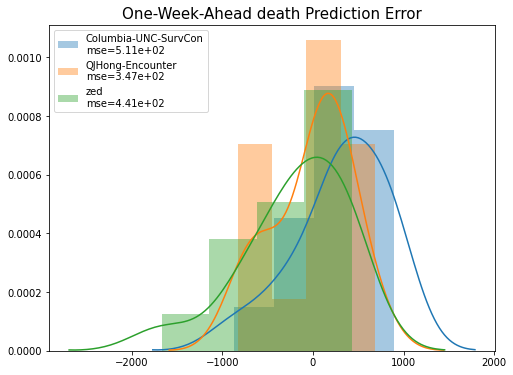

In [417]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# cols = ['Columbia-UNC-SurvCon', 'QJHong-Encounter', 'ET1', 'RF1', 'TF1', 'avg1', 'med1']
cols = ['Columbia-UNC-SurvCon', 'QJHong-Encounter', 'zed']
# cols = ['Columbia-UNC-SurvCon', 'QJHong-Encounter', 'RF1', 'ET1']

df_tmp = df_combined_1.loc['2020-07-25':'2020-10-31', :]
print(df_tmp)

for col in cols:
    if col == 'grd1':
        continue
    err = ((df_tmp[col] - df_tmp['grd1']) / df_tmp['grd1']).values
    err = (df_tmp[col] - df_tmp['grd1']).values
    # mse = np.sqrt((err ** 2).mean())
    mse = np.abs(err).mean()
    sns.distplot(err, ax=ax, label=f'{col}\nmse={mse:.2e}')
ax.legend()
ax.set_title(f'One-Week-Ahead {target} Prediction Error', fontsize=15)

In [418]:
df_combined_1.to_csv(f'results_forecast/forecast_compare_{target}_{idx}.csv', float_format='%.0f')
df_combined_1.to_csv(f'../../COVID_risk/Figures/data/forecast_compare_{target}_{idx}.csv', float_format='%.0f')

## 1-week-ahead

In [419]:
ylim = np.array([np.nanmin(df_otherTeams_1.values), np.nanmax(df_otherTeams_1.values)])
margin = (ylim[1] - ylim[0]) * .05
ylim = [ylim[0] - margin, ylim[1] + margin]
figsize = (15, 7.5)

(4350.8, 7875.2)

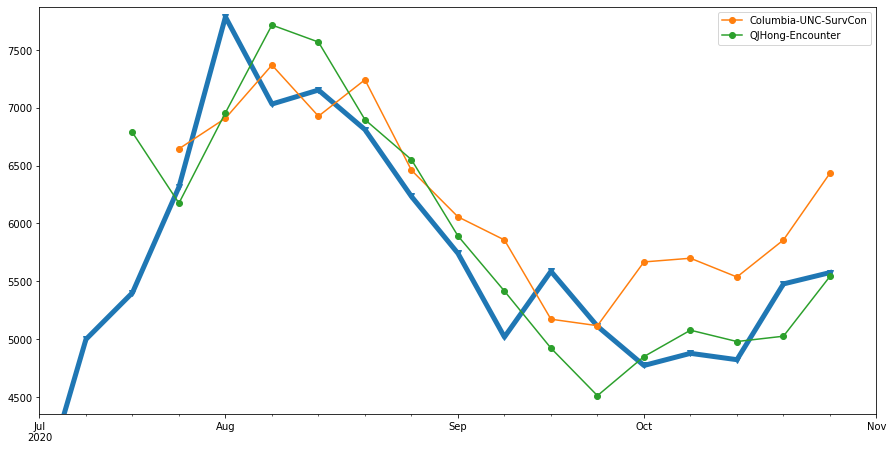

In [420]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
df_ours_1.loc['2020-07-01':, 'grd1'].plot(ax=ax, marker='v', linewidth=5)
df_otherTeams_1.plot(ax=ax, marker='o')
ax.set_ylim(ylim)

<AxesSubplot:>

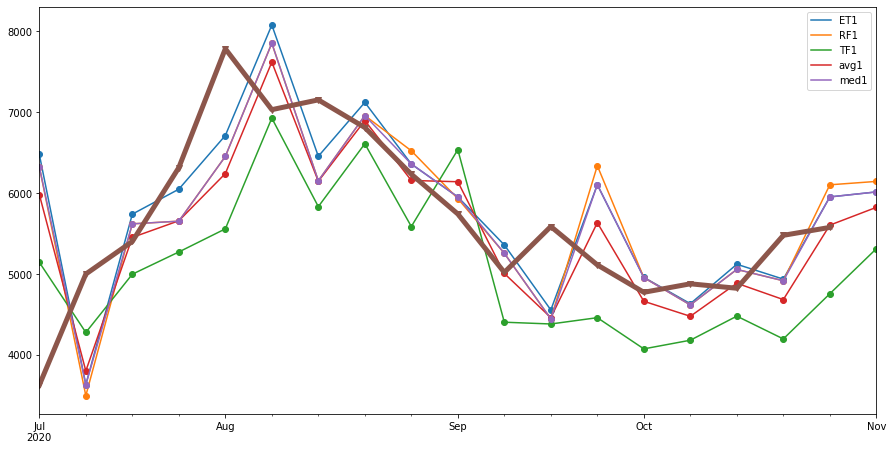

In [421]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
df_ours_1.loc['2020-07-01':].drop('grd1', axis=1).plot(ax=ax, marker='o')
df_ours_1.loc['2020-07-01':, 'grd1'].plot(ax=ax, marker='v', linewidth=5)
# ax.set_ylim(ylim)

Text(0.5, 1.0, 'One-Week-Ahead Prediction Error')

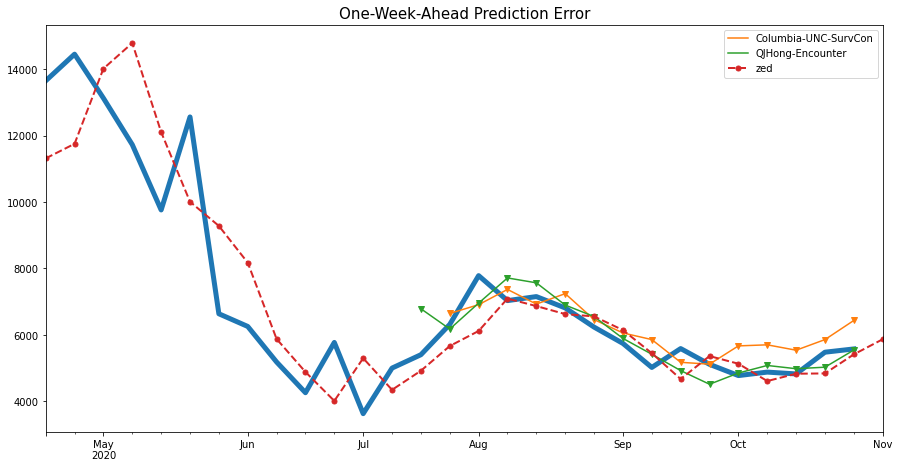

In [422]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
df_ours_1.loc[:, 'grd1'].plot(ax=ax, linewidth=5)
df_otherTeams_1[['Columbia-UNC-SurvCon', 'QJHong-Encounter']].plot(ax=ax, marker='v')
df_combined_1[['zed']].plot(ax=ax, marker='o', style='--', linewidth=2, ms=5)
# df_ours_1.loc['2020-07-01':][['avg1', 'med1', 'TF1', 'RF1', 'ET1']].plot(ax=ax, marker='o', style='--')
ax.set_title('One-Week-Ahead Prediction Error', fontsize=15)
# ax.set_ylim(ylim)

results_forecast/forecast_US_tweak_00.csv
            Columbia-UNC-SurvCon  QJHong-Encounter     ET1     RF1     TF1  \
2020-07-25              474855.0          527148.0  502391  504637  422826   
2020-08-01              432387.0          480241.0  457560  455936  417574   

                grd1    avg1    med1  
2020-07-25  455720.0  476618  502391  
2020-08-01  431892.0  443690  455936  
results_forecast/forecast_US_tweak_01.csv
            Columbia-UNC-SurvCon  QJHong-Encounter     ET1     RF1     TF1  \
2020-07-25              474855.0          527148.0  496737  496907  423310   
2020-08-01              432387.0          480241.0  460126  459302  417324   

                grd1    avg1    med1  
2020-07-25  455720.0  472318  496737  
2020-08-01  431892.0  445584  459302  
results_forecast/forecast_US_tweak_02.csv
            Columbia-UNC-SurvCon  QJHong-Encounter     ET1     RF1     TF1  \
2020-07-25              474855.0          527148.0  501636  497145  423190   
2020-08-01    

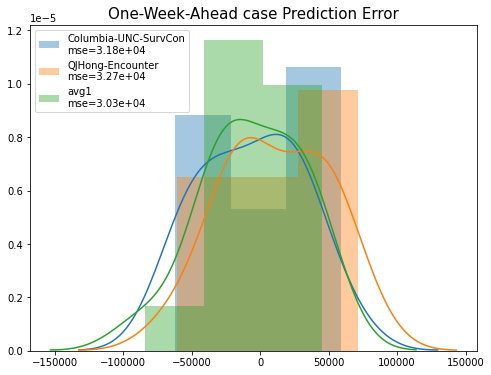

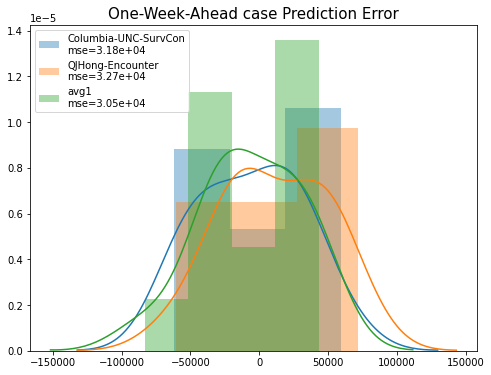

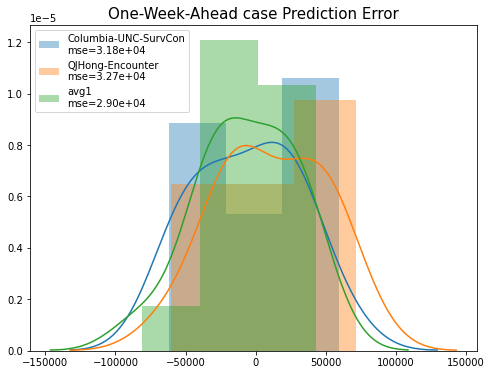

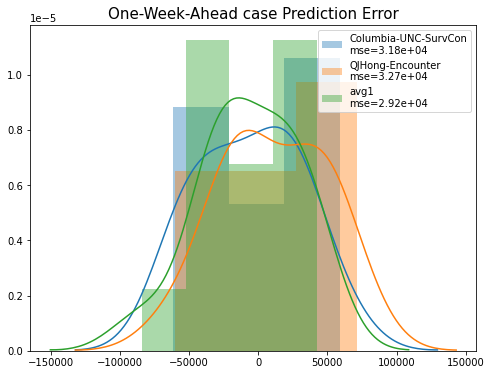

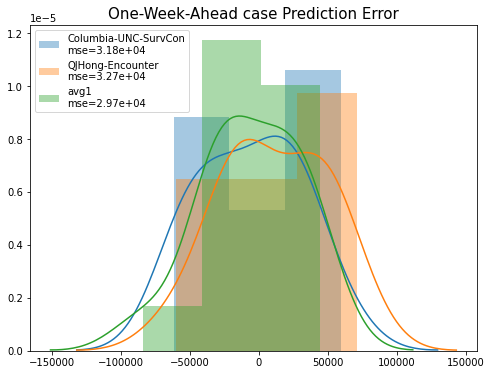

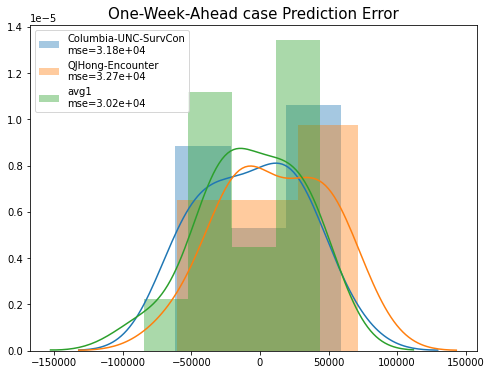

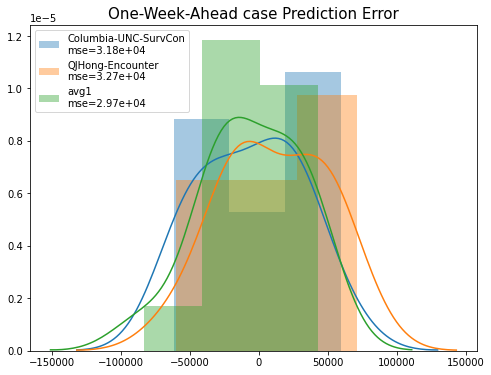

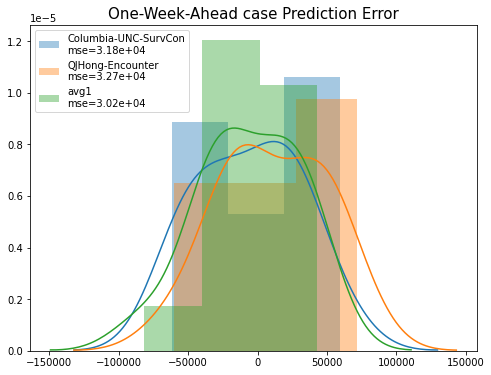

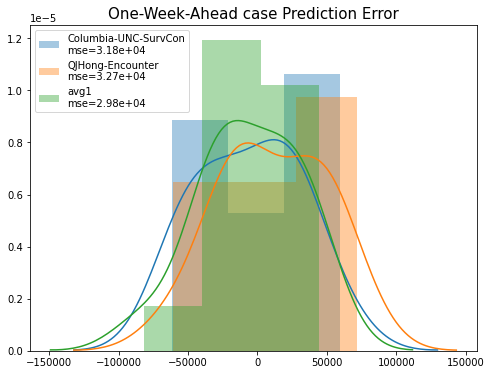

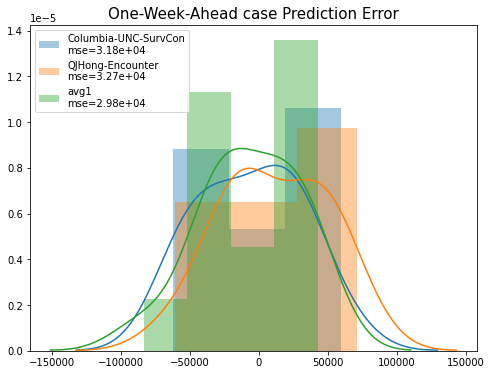

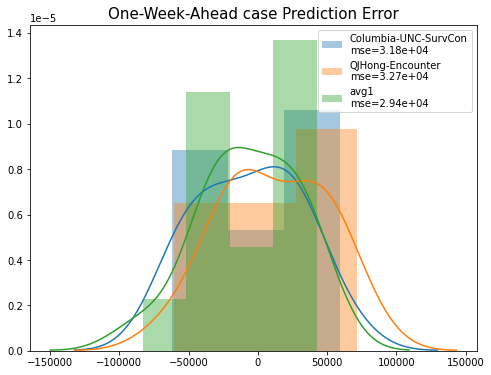

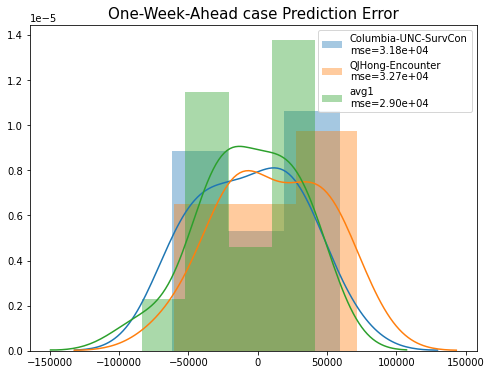

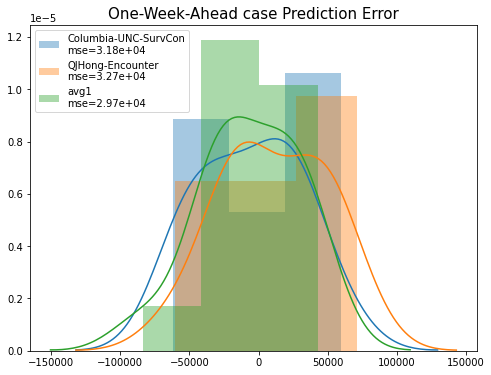

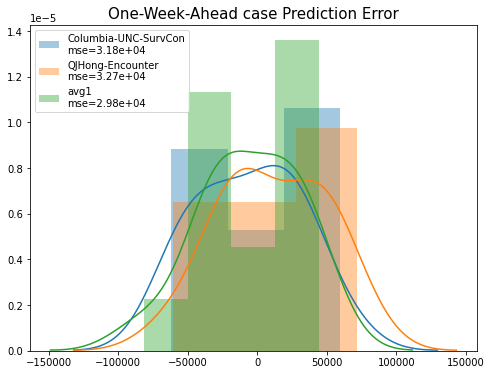

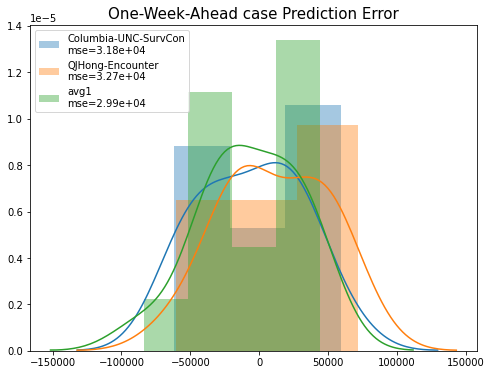

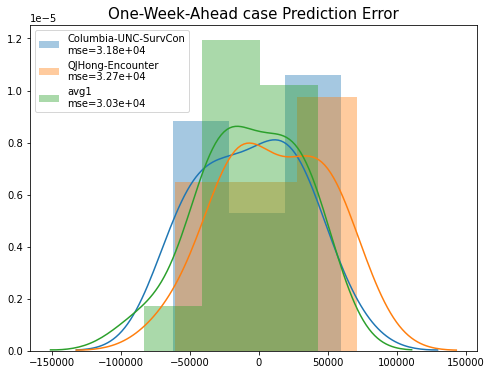

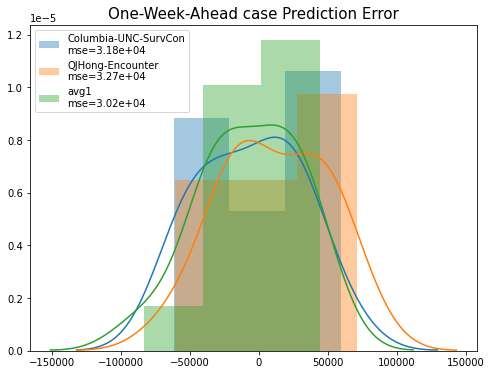

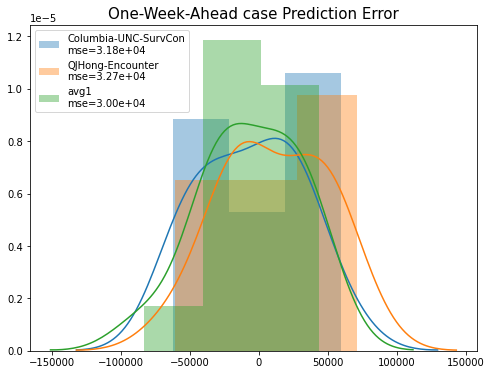

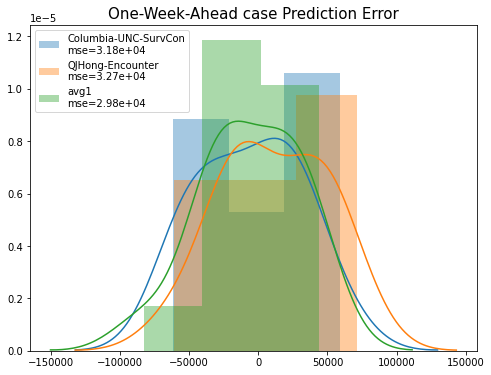

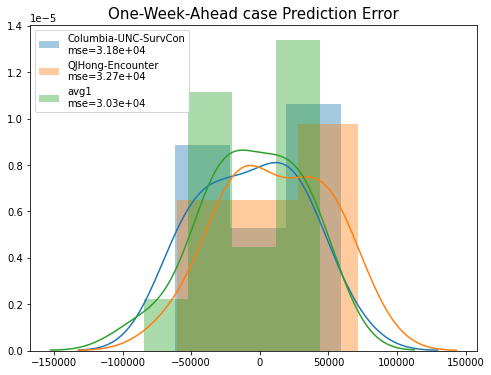

In [29]:
csv_fname = f'results_forecast/forecast_US_tweak_00.csv'

mses =[]
for idx in range(20): 
    idx = str(idx).zfill(2)
    csv_fname = f'results_forecast/forecast_US_tweak_{idx}.csv'
    print(csv_fname)
    
    # idx = csv_fname.split('/')[-1][:-4].split('_')[-1]

    df_ours = pd.read_csv(csv_fname, index_col=0)
    
    dates = pd.date_range(start='2020-04-11', freq='7D', periods=len(df_ours))

    
    
    df_otherTeams_1 = pd.read_csv(f'../CovidTeam_results/forecast_otherTeam_1-wk-ahead-inc-case.csv', index_col=0, parse_dates=True)
    dates_1 = dates + timedelta(days=7)

    cols = [x for x in df_ours.columns if x.endswith('1')]
    df_ours_1 = df_ours[cols]
    df_ours_1.index = dates_1
    df_combined_1 = df_otherTeams_1.join(df_ours_1, how='outer')
    
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    # cols = ['Columbia-UNC-SurvCon', 'QJHong-Encounter', 'ET1', 'RF1', 'TF1', 'avg1', 'med1']
    cols = ['Columbia-UNC-SurvCon', 'QJHong-Encounter', 'avg1']
    # cols = ['Columbia-UNC-SurvCon', 'QJHong-Encounter', 'RF1', 'ET1']

    df_tmp = df_combined_1.loc['2020-07-25':'2020-10-31', :].dropna()
    # print(df_tmp)
    print(df_tmp.head(2))
    
    for col in cols:
        if col == 'grd1':
            continue
        err = ((df_tmp[col] - df_tmp['grd1']) / df_tmp['grd1']).values
        err = (df_tmp[col] - df_tmp['grd1']).values
        # mse = np.sqrt((err ** 2).mean())
        mse = np.abs(err).mean()
        if col == 'avg1':
            mses.append(mse)
        
        sns.distplot(err, ax=ax, label=f'{col}\nmse={mse:.2e}')
    ax.legend()
    ax.set_title(f'One-Week-Ahead {target} Prediction Error', fontsize=15)

In [30]:
np.mean(mses)

29832.757142857143

In [31]:
mses

[30339.071428571428,
 30467.0,
 28968.5,
 29216.785714285714,
 29660.35714285714,
 30236.928571428572,
 29735.928571428572,
 30225.64285714286,
 29782.285714285714,
 29792.85714285714,
 29375.428571428572,
 28987.428571428572,
 29661.571428571428,
 29789.928571428572,
 29925.0,
 30294.285714285714,
 30161.071428571428,
 29969.785714285714,
 29799.35714285714,
 30265.928571428572]